In [27]:
import pandas as pd
import pickle
from engarde.decorators import has_dtypes
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from capstone_project import preprocessor

In [2]:
# Make sure that the loaded dataframe has the correct layout otherwise throw assertion error 
@has_dtypes(dict(question1=object, question2=object, is_duplicate=int))
def load_and_check_data(filename):
    """Load dataframe using filename as input. A pandas dataframe is returned and it is checked that it 
    has the layout that is defined by the decorators.
    """
    df = pd.read_pickle(filename)
    df.fillna("", inplace=True)  # Two questions have empty fields
    return df

In [17]:
# The current working directory for python is the capstone_project/notebook folder
file_directory = "../output/data/"

X = load_and_check_data(file_directory+"train_data.pkl")
X = X[0:1000]

In [45]:
tfidf = preprocessor.TfidfTransformer()
feature_engineering = preprocessor.FeatureTransformer()

y = X["is_duplicate"].values

feature_creator = FeatureUnion([('feature_engineering', feature_engineering), ('tfidf', tfidf)])
clf = LogisticRegression()


#pipe = Pipeline([("features", feature_creator), ("logistic", clf)])
pipe = Pipeline([("features", feature_engineering), ("logistic", clf)])

print pipe.get_params().keys()

['logistic__max_iter', 'logistic__verbose', 'features', 'logistic__solver', 'logistic__tol', 'logistic__penalty', 'logistic__dual', 'logistic__fit_intercept', 'logistic__warm_start', 'steps', 'logistic__multi_class', 'logistic', 'logistic__class_weight', 'logistic__C', 'logistic__random_state', 'logistic__intercept_scaling', 'logistic__n_jobs']


In [46]:
#http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [47]:
from scipy.stats import uniform
from time import time

skf = StratifiedKFold(n_splits=3, random_state=12574, shuffle=True)

#print cross_val_score(pipe, X, y, scoring="neg_log_loss", cv=skf)
#print cross_val_score(pipe, X, y, scoring="accuracy", cv=skf)

param_dist = {"logistic__C": uniform(0, 5)}
n_iter_search = 20
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter_search, cv=skf, scoring="neg_log_loss")
random_search.fit(X, y)
              
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)  

#for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y[train_index], y[test_index]

RandomizedSearchCV took 4.19 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.539 (std: 0.028)
Parameters: {'logistic__C': 3.7626408141684791}

Model with rank: 2
Mean validation score: -0.539 (std: 0.028)
Parameters: {'logistic__C': 3.9418171388142396}

Model with rank: 3
Mean validation score: -0.539 (std: 0.028)
Parameters: {'logistic__C': 4.0719355383191651}



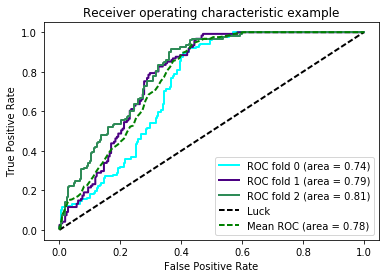

In [77]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
import matplotlib.pyplot as plt

best_pipe = random_search.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen'])
lw = 2

i = 0
for (train_index, test_index), color in zip(skf.split(X, y), colors):
    pred = best_pipe.predict_proba(X.iloc[test_index])
    fpr, tpr, thresholds = roc_curve(y[test_index], pred[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= skf.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [6]:
def save_output(dataset, filename):
    with open (filename, "wb") as handle:
        pickle.dump(dataset, handle)

In [23]:
output_directory = "../output/models/"
prefix = "first_test_"


save_output(skf, output_directory+prefix+"kfolds.pkl") 
save_output(pipe, output_directory+prefix+"logistic_pipeline.pkl") 

1
2
3
